compare different sample lengths of picture description feature sets against eachother

In [4]:
import os, sys, numpy as np, pandas as pd
from sklearn.ensemble import RandomForestRegressor

# add project root
sys.path.append("/Users/gilanorup/Desktop/Studium/MSc/MA/code/masters_thesis_gn/src")

from config.constants import GIT_DIRECTORY
from config.feature_sets import get_linguistic_features, get_acoustic_features

USE_FILTERED_SUFFIX = "_filtered"   # or "_filtered2"

tasks = [
    "picture_description_1min",
    "picture_description_2min",
    "picture_description" # (random length but max 5min)
]

# targets
score_names = ["PictureNamingScore","SemanticFluencyScore","PhonemicFluencyScore"]

# feature set list
model_order = ["baseline","demographics","acoustic","linguistic","linguistic+acoustic","full"]

# estimator & hyperparams
model_type  = RandomForestRegressor
model_params = {
    "n_estimators": 625, "random_state": 42, "min_samples_leaf": 4,
    "max_features": "sqrt", "bootstrap": True, "max_depth": 14, "min_samples_split": 9
}

# folders
oof_dir    = os.path.join(GIT_DIRECTORY, "results", "regression", "oof_results", "oof_results_picture_description")
results_dir = os.path.join(GIT_DIRECTORY, "results", "regression", "picture_description")
os.makedirs(oof_dir, exist_ok=True); os.makedirs(results_dir, exist_ok=True)

# data
scores_df    = pd.read_csv(os.path.join(GIT_DIRECTORY, "data/language_scores_all_subjects.csv"))
demographics = pd.read_csv(os.path.join(GIT_DIRECTORY, "data/demographics_data.csv"))

scores_df["Subject_ID"] = scores_df["Subject_ID"].astype(str)
demographics["Subject_ID"] = demographics["Subject_ID"].astype(str)


# set up demographics
for col in ["Gender","Education","Country"]:
    demographics[col] = demographics[col].astype("string").str.lower().str.strip()
demographics["Socioeconomic"] = pd.to_numeric(demographics["Socioeconomic"], errors="coerce")
demographics["Gender"] = demographics["Gender"].map({"f":0, "m":1})
education_map = {"less_than_highschool":1,"high_school":2,"vocational":3,"bachelor":4,"master":5,"phd":6,"no_answer":np.nan}
demographics["Education"] = demographics["Education"].map(education_map)
demographics["Education_level"] = demographics["Education"].map({1:0, 2:1, 3:1, 4:2, 5:2, 6:2})
demographics["Country"] = demographics["Country"].map({"uk":0,"usa":1})
demographics.drop(columns=["Language"], inplace=True, errors="ignore")

# model configs
linguistic = get_linguistic_features()
acoustic   = get_acoustic_features()
demographic_feats = ["Age","Gender","Education_level","Country","Socioeconomic"]
model_configs = {"full": sorted(list(linguistic | acoustic)) + demographic_feats}

# plotting/test order
task_order = [
    "picture_description",
    "picture_description_2min",
    "picture_description_1min",
]
score_order = ["PictureNamingScore","SemanticFluencyScore","PhonemicFluencyScore"]

# bootstrapping
N_BOOT = 1000
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [5]:
# helpers
from regression.regression_helpers import stratified_cross_validation
from regression.model_evaluation_helpers import (
    load_task_dataframe as _load_task_dataframe_orig,
    get_model_feature_list, complete_subjects, normalize_oof_df,
    bootstrap_summary_from_oof, bootstrap_metrics_from_oof,
    pairwise_score_tests_for_task, pairwise_task_tests_for_scores, pairwise_model_tests_for_task_target
)

def load_task_dataframe(task_name, target, scores, demographics):
    features_path = os.path.join(GIT_DIRECTORY, f"results/features/filtered/{task_name}{USE_FILTERED_SUFFIX}.csv")
    folds_path = os.path.join(GIT_DIRECTORY, "data/stratified_folds.csv")

    features = pd.read_csv(features_path)
    folds = pd.read_csv(folds_path)

    for df in (features, scores, demographics, folds):
        df["Subject_ID"] = df["Subject_ID"].astype(str)

    df = pd.merge(features, scores[["Subject_ID", target]], on="Subject_ID")
    df = pd.merge(df, demographics, on="Subject_ID")
    df = pd.merge(df, folds[["Subject_ID", "fold"]], on="Subject_ID")
    return df


In [6]:
ID = "Subject_ID"

def feature_columns(df):
    drop = {ID, "fold"} | set(score_names)
    return sorted([c for c in df.columns if c not in drop])

# check feature columns line up across all tasks (using one score just to load)
tmp = {t: load_task_dataframe(t, score_names[0], scores_df, demographics) for t in tasks}
for t in tasks: tmp[t][ID] = tmp[t][ID].astype(str)

ref = feature_columns(tmp[tasks[0]])
print("Reference feature count:", len(ref))
for t in tasks[1:]:
    cur = feature_columns(tmp[t])
    missing = [c for c in ref if c not in cur]
    extra   = [c for c in cur if c not in ref]
    print(f"{t}: features={len(cur)} | -missing={len(missing)} | +extra={len(extra)}")

# subject intersection per target (based on 'full' features)
for tgt in score_names:
    dfs_t = {t: load_task_dataframe(t, tgt, scores_df, demographics) for t in tasks}
    cols_by_task = {t: get_model_feature_list(dfs_t[t].columns, model_configs["full"], tgt) for t in tasks}
    subject_sets = [complete_subjects(dfs_t[t], cols_by_task[t], tgt) for t in tasks]
    inter = set.intersection(*subject_sets)
    print(f"{tgt}: N subjects in complete intersection across all 5 tasks = {len(inter)}")


Reference feature count: 59
picture_description_2min: features=59 | -missing=0 | +extra=0
picture_description: features=59 | -missing=0 | +extra=0
PictureNamingScore: N subjects in COMPLETE intersection across all 5 tasks = 969
SemanticFluencyScore: N subjects in COMPLETE intersection across all 5 tasks = 981
PhonemicFluencyScore: N subjects in COMPLETE intersection across all 5 tasks = 981


In [7]:
# cross-validation and OOF predictions
all_oof_rows = []
fold_rows = []

for tgt in score_names:
    task_dfs = {t: load_task_dataframe(t, tgt, scores_df, demographics) for t in tasks}

    for t in tasks:
        task_dfs[t]["Subject_ID"] = task_dfs[t]["Subject_ID"].astype(str)

    full_cols_by_task = {t: get_model_feature_list(task_dfs[t].columns, model_configs["full"], tgt) for t in tasks}

    subject_sets = [set(map(str, complete_subjects(task_dfs[t], full_cols_by_task[t], tgt))) for t in tasks]
    full_subjects = set.intersection(*subject_sets)
    print(f"\n{tgt}: intersection of subjects across all tasks: N={len(full_subjects)}")

    if len(full_subjects) == 0:
        for t in tasks:
            n_rows = len(task_dfs[t])
            n_feats = len(full_cols_by_task[t])
            n_complete = len(set(map(str, complete_subjects(task_dfs[t], full_cols_by_task[t], tgt))))
            print(f"  - {t}: rows={n_rows}, feat_cols={n_feats}, complete_subjects={n_complete}")
        raise RuntimeError(f"[STOP] No subject intersection for target={tgt}.")

    for t in tasks:
        df_t = task_dfs[t].copy()
        before = len(df_t)
        df_t = df_t[df_t["Subject_ID"].isin(full_subjects)].copy()
        print(f"{tgt} | {t}: kept {len(df_t)}/{before} rows after subject intersection.")

        # full model only
        model_name, selected = "full", model_configs["full"]
        fcols = get_model_feature_list(df_t.columns, selected, tgt)
        if not fcols:
            print(f"{tgt} | {t} | {model_name}: 0 feature columns matched.")
            continue

        miss_tgt  = df_t[tgt].isna().sum()
        miss_feat = df_t[fcols].isna().any(axis=1).sum()
        df_use = df_t.dropna(subset=[tgt] + fcols).copy()
        print(f"{tgt} | {t} | {model_name}: fcols={len(fcols)}, NaN target rows={miss_tgt}, "
              f"any NaN in features rows={miss_feat}, usable={len(df_use)}")

        if df_use.empty:
            continue

        X = df_use[fcols]
        mtype, mparams = model_type, model_params

        model_df = pd.concat([df_use[["Subject_ID","fold"]], X, df_use[tgt].rename(tgt)], axis=1)
        print(f"{t} | {model_name} | N={len(model_df)} | features={len(fcols)}")

        r2_list, rmse_list, mae_list, all_preds = stratified_cross_validation(
            df=model_df,
            fold_column="fold",
            model_type=mtype,
            model_params=mparams,
            target_column=tgt,
            feature_columns=fcols
        )

        if all_preds is None or all_preds.empty:
            print(f"WARNING: empty predictions for {t} / {tgt} — skipping.")
            continue

        for k, (r2, rmse, mae) in enumerate(zip(r2_list, rmse_list, mae_list)):
            fold_rows.append({"target":tgt,"task":t,"model":model_name,"fold":k,
                              "r2":r2,"rmse":rmse,"mae":mae,"estimator":mtype.__name__})

        all_preds = all_preds.rename(columns={"y_test":"y_true"})
        oof_df = normalize_oof_df(all_preds, target_col=tgt)
        oof_df["task"] = t; oof_df["model"] = model_name; oof_df["target"] = tgt

        cols_keep = ["Subject_ID", "Age", "Gender", "Education_level", "Country"]
        oof_df = oof_df.merge(demographics[cols_keep], on="Subject_ID", how="left")
        all_oof_rows.append(oof_df)

if not all_oof_rows:
    raise RuntimeError("No OOF rows were produced after fixes.")
oof_all = pd.concat(all_oof_rows, ignore_index=True)
fold_df = pd.DataFrame(fold_rows)
oof_all.to_csv(os.path.join(oof_dir, "oof_preds_all_scores.csv"), index=False)
fold_df.to_csv(os.path.join(oof_dir, "cv_folds_all_scores.csv"), index=False)
print("\nSaved OOF and fold metrics.")



PictureNamingScore: intersection of subjects across all tasks: N=969
PictureNamingScore | picture_description_1min: kept 969/982 rows after subject intersection.
PictureNamingScore | picture_description_1min | full: fcols=58, NaN target rows=0, any NaN in features rows=0, usable=969
picture_description_1min | full | N=969 | features=58
PictureNamingScore | picture_description_2min: kept 969/982 rows after subject intersection.
PictureNamingScore | picture_description_2min | full: fcols=58, NaN target rows=0, any NaN in features rows=0, usable=969
picture_description_2min | full | N=969 | features=58
PictureNamingScore | picture_description: kept 969/982 rows after subject intersection.
PictureNamingScore | picture_description | full: fcols=58, NaN target rows=0, any NaN in features rows=0, usable=969
picture_description | full | N=969 | features=58

SemanticFluencyScore: intersection of subjects across all tasks: N=981
SemanticFluencyScore | picture_description_1min: kept 981/982 rows

In [8]:
# bootstrap summaries
for tgt in score_names:
    oof_score = oof_all[oof_all["target"] == tgt].copy()

    _, summ_df = bootstrap_summary_from_oof(
        oof_score, group_cols=("target","task","model"),
        n_boot=N_BOOT, ci=0.95, random_state=RANDOM_STATE
    )
    summ_df.to_csv(os.path.join(oof_dir, f"bootstrap_summary_{tgt}.csv"), index=False)

    met = bootstrap_metrics_from_oof(
        oof_score, group_cols=("target","task","model"),
        n_boot=N_BOOT, ci=0.95, random_state=RANDOM_STATE
    )
    met.to_csv(os.path.join(oof_dir, f"bootstrap_metrics_{tgt}.csv"), index=False)


In [9]:
# compare tasks within one score
display_labels = {
    "picture_description_1min": "Picture Description (1min)",
    "picture_description_2min": "Picture Description (2min)",
    "picture_description": "Picture Description (≤ 5min)"
}

from itertools import combinations
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import textwrap

# 1) stats: pairwise bootstrap tests across tasks for one score
def pairwise_task_tests_for_one_score(
    oof_preds,
    target="SemanticFluencyScore",
    model="full",
    tasks=None,
    n_boot=1000,
    adjust="holm",
    random_state=42,
    subject_set=None,
):
    if tasks is None:
        raise ValueError("Provide tasks explicitly.")

    from regression.model_evaluation_helpers import pairwise_task_tests_for_scores

    df = oof_preds.copy()
    if subject_set is not None:
        df = df[df["Subject_ID"].isin(subject_set)].copy()

    out = pairwise_task_tests_for_scores(
        df,
        scores=(target,),
        tasks=tuple(tasks),
        model=model,
        n_boot=n_boot,
        adjust=adjust,
        random_state=random_state
    )
    out = out[out["target"] == target].copy()
    out.rename(columns={"A":"task_A","B":"task_B"}, inplace=True)
    return out.sort_values("p_adj").reset_index(drop=True)


# 2) plotting: boxes are tasks; brackets show Holm-corrected p-values between tasks
def plot_tasks_box_with_pvals(
    oof_preds,
    target="SemanticFluencyScore",
    model="full",
    order_tasks=("picnicScene","picture_description_mean","picture_description","picture_description_2min","picture_description_1min"),
    n_boot=1000,
    ci=0.95,
    random_state=42,
    subject_set=None,
    adjust="holm",
    save_path=None,
    pairs_to_show=None,
    box_top_pad_frac=0.06,     # space above tallest box to first bracket
    bracket_gap_frac=0.08,     # vertical gap between bracket lanes
    bracket_height_frac=0.02, # bracket little “legs” height
    bottom_pad_frac=0.03,      # small pad below shortest box
    label_extra_pad_frac=0.010 # a touch of extra headroom for text above top bracket
):
    from regression.model_evaluation_helpers import bootstrap_summary_from_oof
    from pandas.api.types import CategoricalDtype
    import numpy as np, seaborn as sns, matplotlib.pyplot as plt, textwrap, os, math
    from matplotlib.ticker import MultipleLocator, FormatStrFormatter

    # data subset & order
    sub = oof_preds[(oof_preds["target"] == target) & (oof_preds["model"] == model)].copy()
    if subject_set is not None:
        sub = sub[sub["Subject_ID"].isin(subject_set)].copy()
    cat_task = CategoricalDtype(categories=list(order_tasks), ordered=True)
    sub["task"] = sub["task"].astype(cat_task)

    # bootstrap distributions for boxes
    boot_df, _ = bootstrap_summary_from_oof(
        sub, group_cols=("task",), n_boot=n_boot, ci=ci, random_state=random_state, subject_set=None
    )
    boot_df["task"] = boot_df["task"].astype(cat_task)

    # pairwise tests (Holm-corrected)
    test_df = pairwise_task_tests_for_one_score(
        oof_preds, target=target, model=model, tasks=tuple(order_tasks),
        n_boot=n_boot, adjust=adjust, random_state=random_state
    )
    if pairs_to_show is not None:
        want = {tuple(sorted(p)) for p in pairs_to_show}
        test_df = test_df[test_df.apply(
            lambda r: tuple(sorted([r["task_A"], r["task_B"]])) in want, axis=1
        )].copy()

    sns.set_theme(context="paper", style="whitegrid")

    # plot boxes
    fig, ax = plt.subplots(figsize=(max(6, 1*len(order_tasks)), 3.6))
    pal = sns.color_palette("crest", n_colors=len(order_tasks))
    sns.boxplot(
        data=boot_df, x="task", y="r2", order=order_tasks,
        palette=pal, width=0.3, showcaps=True, showfliers=False,
        whis=(2.5, 97.5), showmeans=True, meanline=True,
        meanprops=dict(color="#111", linewidth=0.8, linestyle="-"),
        medianprops=dict(color="none", linewidth=0),
        linewidth=0.8, ax=ax
    )

    ax.margins(x=0.12)                 # add ~12% space left/right
    fig.subplots_adjust(bottom=0.18)   # a bit more room for labels

    # compute dynamic pads in data units
    y_lo = float(boot_df["r2"].min())
    y_hi = float(boot_df["r2"].max())
    y_span = max(1e-9, y_hi - y_lo)

    box_top_pad   = box_top_pad_frac   * y_span
    bracket_gap   = bracket_gap_frac   * y_span
    bracket_h     = bracket_height_frac* y_span
    bottom_pad    = bottom_pad_frac    * y_span
    label_extra   = label_extra_pad_frac * y_span

    # helper: label text
    def _p_to_label(p, stars=True, decimals=3):
        if p is None or not np.isfinite(p): return "n/a"
        s = "***" if p < 0.001 else "**" if p < 0.01 else "*" if p < 0.05 else "ns"
        val = f"{p:.{decimals}f}".lstrip("0")
        return f"{s} (p={val})" if stars else f"p={val}"

    #  bracket lane assignment (avoid overlaps)
    idx = {t:i for i,t in enumerate(order_tasks)}
    rows = []
    for r in test_df.itertuples(index=False):
        i, j = idx[r.task_A], idx[r.task_B]
        rows.append((abs(i-j), min(i,j), max(i,j), r))
    rows.sort(reverse=True)  # place longest first

    lanes, placed = [], []
    for _, L, R, row in rows:
        for lane_i, lane in enumerate(lanes):
            if all(R <= lL or L >= lR for (lL, lR) in lane):
                lane.append((L, R)); placed.append((row, lane_i)); break
        else:
            lanes.append([(L, R)]); placed.append((row, len(lanes)-1))

    # x positions for bracket ends (centers of boxes)
    x_centers = np.arange(len(order_tasks), dtype=float)

    #  y levels for brackets in DATA coords
    first_bracket_y = y_hi + box_top_pad
    top_bracket_y = first_bracket_y + (max(0, len(lanes)-1))*(bracket_h + bracket_gap) + label_extra

    # draw brackets (in DATA coords)
    for row, lane_i in placed:
        i, j = idx[row.task_A], idx[row.task_B]
        xi, xj = x_centers[i], x_centers[j]
        y_top = first_bracket_y + lane_i*(bracket_h + bracket_gap)
        y0 = y_top - bracket_h
        ax.plot([xi, xi, xj, xj], [y0, y_top, y_top, y0],
                lw=0.9, color="#333", clip_on=False)
        ax.text((xi + xj)/2, y_top, _p_to_label(row.p_adj),
                ha="center", va="bottom", fontsize=8, clip_on=False)

    # tight y-limits: just enough for brackets + tiny headroom
    y_min = y_lo - bottom_pad
    y_max = top_bracket_y
    ax.set_ylim(y_min, y_max)

    # ticks & labels (two decimals)
    step = 0.05
    lo = math.floor(ax.get_ylim()[0] / step) * step
    hi = math.ceil(ax.get_ylim()[1] / step) * step
    ax.set_ylim(lo, hi)
    ax.yaxis.set_major_locator(MultipleLocator(step))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

    ax.set_xlabel("Feature Set Variant", fontsize=12)
    ax.set_ylabel("R\u00B2 (bootstrapped)", fontsize=12)

    # x labels: single line
    wrapped = [display_labels.get(t, t).replace("_", " ") for t in order_tasks]
    ax.set_xticklabels(wrapped, rotation=0, ha="center")

    # plot style
    ax.grid(True, axis="y", which="major", linestyle=":", linewidth=0.8, color="#9AA0A6", alpha=0.55)
    for side in ("top","right"): ax.spines[side].set_visible(False)

    plt.tight_layout()
    if save_path:
        os.makedirs(save_path, exist_ok=True)
        out = os.path.join(save_path, f"{target}_tasks_boxplot_with_pvals.png")
        plt.savefig(out, dpi=600, bbox_inches="tight")
    plt.show()

    return test_df


/var/folders/py/1h2n_yxd7l9dts6tjm4v1tpr0000gn/T/ipykernel_33185/1459028993.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/py/1h2n_yxd7l9dts6tjm4v1tpr0000gn/T/ipykernel_33185/1459028993.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped, rotation=0, ha="center")


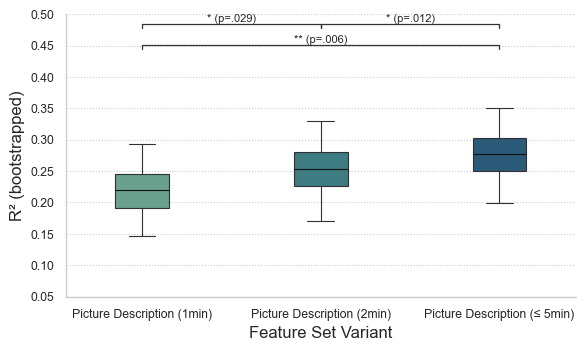

/var/folders/py/1h2n_yxd7l9dts6tjm4v1tpr0000gn/T/ipykernel_33185/1459028993.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/py/1h2n_yxd7l9dts6tjm4v1tpr0000gn/T/ipykernel_33185/1459028993.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped, rotation=0, ha="center")


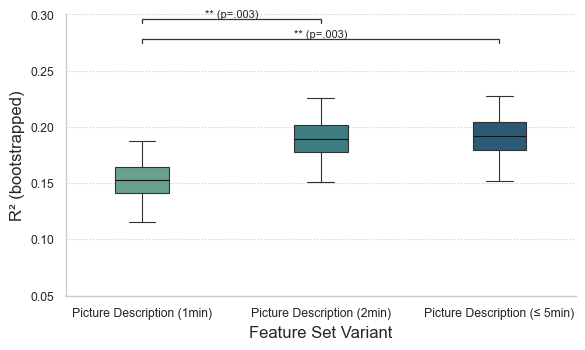

/var/folders/py/1h2n_yxd7l9dts6tjm4v1tpr0000gn/T/ipykernel_33185/1459028993.py:105: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/py/1h2n_yxd7l9dts6tjm4v1tpr0000gn/T/ipykernel_33185/1459028993.py:187: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(wrapped, rotation=0, ha="center")


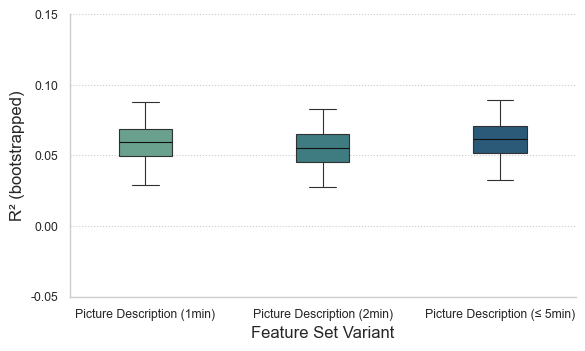

In [10]:
# load OOF
oof_all = pd.read_csv(os.path.join(oof_dir, "oof_preds_all_scores.csv"))

def subject_intersection_for(oof, target, tasks_subset):
    sub = oof[(oof["target"] == target) & (oof["model"] == "full")].copy()
    have = (sub.groupby(["Subject_ID","task"])
              .size()
              .reset_index(name="n"))
    wide = have.pivot_table(index="Subject_ID", columns="task", values="n", fill_value=0)
    need = [t for t in tasks_subset if t in wide.columns]
    if not need:
        return set()
    mask = (wide[need] > 0).all(axis=1)
    return set(wide.index[mask])

# orders
task_order_duration = [
    "picture_description_1min",
    "picture_description_2min",
    "picture_description",
]

# save
output_directory = os.path.join(results_dir, "picture_description_analyses")
os.makedirs(output_directory, exist_ok=True)

for tgt in score_names:
    subjA = subject_intersection_for(oof_all, tgt, task_order_duration)
    testsA = pairwise_task_tests_for_one_score(
        oof_all, target=tgt, model="full",
        tasks=tuple(task_order_duration), n_boot=N_BOOT, adjust="holm", random_state=RANDOM_STATE,
        subject_set=subjA
    )

    # save full comparison table
    dur_outdir = os.path.join(output_directory, "duration_effect")
    os.makedirs(dur_outdir, exist_ok=True)
    testsA.to_csv(os.path.join(dur_outdir, f"{tgt}_duration_pairwise_tests.csv"), index=False)

    # plot
    sigA = [(r.task_A, r.task_B) for _, r in testsA.iterrows() if r.p_adj < 0.05]
    _ = plot_tasks_box_with_pvals(
        oof_all, target=tgt, model="full",
        order_tasks=task_order_duration, pairs_to_show=sigA,
        subject_set=subjA,
        n_boot=N_BOOT, random_state=RANDOM_STATE,
        save_path=dur_outdir
    )
